In [1]:
import numpy as np
import pandas as pd

In [2]:
irisDataset = pd.read_csv("data/iris.data", names=["sepallength","sepalwidth","petallength","petalwidth","class"])
irisDataset

,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


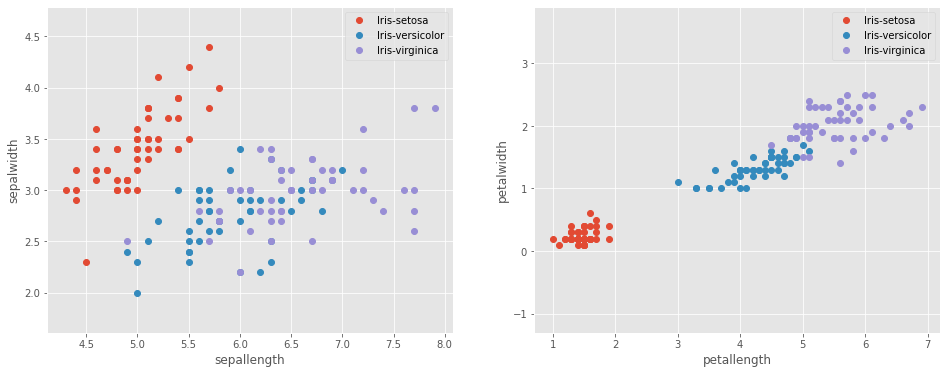

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
nomeClases = irisDataset["class"].unique()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
for target, target_name in enumerate(nomeClases):
    X_plot = irisDataset[irisDataset["class"] == target_name]
    ax1.plot(X_plot["sepallength"], X_plot["sepalwidth"], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax1.set_xlabel("sepallength")
ax1.set_ylabel("sepalwidth")
ax1.axis('equal')
ax1.legend()
for target, target_name in enumerate(nomeClases):
    X_plot = irisDataset[irisDataset["class"] == target_name]
    ax2.plot(X_plot["petallength"], X_plot["petalwidth"], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax2.set_xlabel("petallength")
ax2.set_ylabel("petalwidth")
ax2.axis('equal')
ax2.legend()

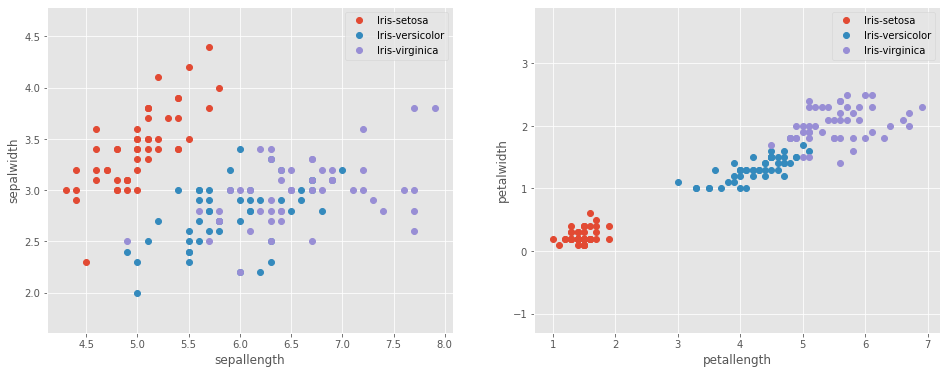

In [4]:

plt.style.use('ggplot')
nomeClases = irisDataset["class"].unique()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
for target, target_name in enumerate(nomeClases):
    X_plot = irisDataset[irisDataset["class"] == target_name]
    ax1.plot(X_plot["sepallength"], X_plot["sepalwidth"], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax1.set_xlabel("sepallength")
ax1.set_ylabel("sepalwidth")
ax1.axis('equal')
ax1.legend()

for target, target_name in enumerate(nomeClases):
    X_plot = irisDataset[irisDataset["class"] == target_name]
    ax2.plot(X_plot["petallength"], X_plot["petalwidth"], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax2.set_xlabel("petallength")
ax2.set_ylabel("petalwidth")
ax2.axis('equal')
ax2.legend()

In [5]:
# Transformacións (en la presentación Iris e Pytorch)
class StandardScaler:

    def __init__(self, mean=None, std=None, epsilon=1e-7):
        """Standard Scaler.
        The class can be used to normalize PyTorch Tensors using native functions. The module does not expect the
        tensors to be of any specific shape; as long as the features are the last dimension in the tensor, the module
        will work fine.
        :param mean: The mean of the features. The property will be set after a call to fit.
        :param std: The standard deviation of the features. The property will be set after a call to fit.
        :param epsilon: Used to avoid a Division-By-Zero exception.
        """
        self.mean = mean
        self.std = std
        self.epsilon = epsilon

    def fit(self, values):
        dims = list(range(values.dim() - 1))
        self.mean = torch.mean(values, dim=dims)
        self.std = torch.std(values, dim=dims)
        

    def transform(self, values):
        return (values - self.mean) / (self.std + self.epsilon)

    def fit_transform(self, values):
        self.fit(values)
        return self.transform(values)

In [7]:
import torch
from torch.utils.data import Dataset
import pandas as pd
class IrisDataset(Dataset):
  def __init__(self, src_file, root_dir, transform=None):
    irisDataset = pd.read_csv(src_file, names=["sepallength","sepalwidth","petallength","petalwidth","class"])
    X = irisDataset[irisDataset.columns.intersection(["sepallength","sepalwidth","petallength","petalwidth"])]
    Y = irisDataset[irisDataset.columns.intersection(["class"])]
    nomeClases = Y["class"].unique()
    conversion = {v: k for k, v in dict(enumerate(nomeClases)).items()}
    YConversion = pd.DataFrame()
    for nome in nomeClases:
      YConversion[nome] = (Y["class"]==nome).apply(lambda x : 1.0 if x else 0.0)
    
    y_tensor = torch.as_tensor(YConversion.to_numpy()).type(torch.float32)
    df_dict = dict.fromkeys(X.columns, '')
    X.rename(columns = df_dict)
    s1=X.iloc[:,0:4].values
    x_tensor = torch.tensor(s1)
    scaler = StandardScaler()
    scaler.fit(x_tensor)
    XScalada = scaler.fit_transform(x_tensor).type(torch.float32)
    self.data = torch.cat((XScalada,y_tensor),1)
    self.root_dir = root_dir
    self.transform = transform
    
  def __len__(self):
    return len(self.data)


  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    preds = self.data[idx, 0:4]
    spcs = self.data[idx, 4:]
    sample = (preds, spcs)
    if self.transform:
      sample = self.transform(sample)
    return sample  


In [8]:
# Cargamos los datos y comprobamos que sae algo
dataset = IrisDataset("data/iris.data",".")
display(dataset[0]) 

(tensor([-0.8977,  1.0286, -1.3368, -1.3086]), tensor([1., 0., 0.]))

In [9]:
# División en train e test
from torch.utils.data import random_split

lonxitudeDataset = len(dataset)
tamTrain =int(lonxitudeDataset*0.8)
tamVal = lonxitudeDataset - tamTrain
print(f"Tam dataset: {lonxitudeDataset} train: {tamTrain} tamVal: {tamVal}")
train_set, val_set = random_split(dataset,[tamTrain,tamVal])
train_ldr = torch.utils.data.DataLoader(train_set, batch_size=2,
    shuffle=True, drop_last=False)
validation_loader =torch.utils.data.DataLoader(val_set, batch_size=4, shuffle=False, num_workers=2)


Tam dataset: 150 train: 120 tamVal: 30


/home/pol/miniconda3/envs/ml_env_linux/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
import torch.nn.functional as F
import torch.nn as nn
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(in_features=50, out_features=3)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x


In [11]:
model     = Model(4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.CrossEntropyLoss()
display(model)

Model(
  (layer1): Linear(in_features=4, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=3, bias=True)
)

In [12]:
# Prueba
entradaProba,dest = next(iter(train_ldr))
print("Entrada:")
display(entradaProba)
print("Desexada:")
display(dest)
saida = model(entradaProba) # esta é a proba de verdade
print("Saída:")
display(saida)
loss_fn(saida, dest)

Entrada:


tensor([[ 1.0345,  0.1061,  0.3635,  0.2638],
        [ 0.5515, -1.2777,  0.7035,  0.9190]])

Desexada:


tensor([[0., 1., 0.],
        [0., 0., 1.]])

Saída:


tensor([[0.3502, 0.2997, 0.3501],
        [0.3635, 0.2862, 0.3503]], grad_fn=<SoftmaxBackward0>)

tensor(1.1073, grad_fn=<DivBackward1>)

## **Entrenamiento**

In [13]:


def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(train_ldr) instead of
    # iter(train_ldr) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_ldr):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 10 == 9:
            last_loss = running_loss / 10 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    return last_loss



In [14]:
EPOCHS = 100
loss_list = torch.zeros((EPOCHS,))
accuracy_list = torch.zeros((EPOCHS,))

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch + 1))

    # Poñemos o modelo en modo entrenamento
    model.train(True)
    avg_loss = train_one_epoch(epoch)#############
    loss_list[epoch] = avg_loss
    # Non se precisan os gradientes para o test
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)

        correct = (torch.argmax(voutputs, dim=0) == vlabels).type(torch.FloatTensor)
        accuracy_list[epoch] += correct.sum()
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {} {}/{}'.format(avg_loss, avg_vloss,accuracy_list[epoch],int(lonxitudeDataset*0.2)))

EPOCH 1:
  batch 10 loss: 1.1018484950065612
  batch 20 loss: 1.0837504506111144
  batch 30 loss: 1.0510174989700318
  batch 40 loss: 1.0339276194572449
  batch 50 loss: 0.996989780664444
  batch 60 loss: 1.0035514831542969


/home/pol/miniconda3/envs/ml_env_linux/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


LOSS train 1.0035514831542969 valid 0.9362858533859253 24.0/30
EPOCH 2:
  batch 10 loss: 0.9218012988567352
  batch 20 loss: 0.8733956456184387
  batch 30 loss: 0.8523699104785919
  batch 40 loss: 0.8938960909843445
  batch 50 loss: 0.7447954714298248
  batch 60 loss: 0.8470860004425049
LOSS train 0.8470860004425049 valid 0.7723027467727661 20.0/30
EPOCH 3:
  batch 10 loss: 0.7677179872989655
  batch 20 loss: 0.7701533496379852
  batch 30 loss: 0.7358689606189728
  batch 40 loss: 0.6977130770683289
  batch 50 loss: 0.7637519657611846
  batch 60 loss: 0.71421177983284
LOSS train 0.71421177983284 valid 0.7438466548919678 20.0/30
EPOCH 4:
  batch 10 loss: 0.6465287327766418
  batch 20 loss: 0.7417050302028656
  batch 30 loss: 0.7238406479358673
  batch 40 loss: 0.7229816675186157
  batch 50 loss: 0.6503775775432586
  batch 60 loss: 0.7103851914405823
LOSS train 0.7103851914405823 valid 0.694915235042572 22.0/30
EPOCH 5:
  batch 10 loss: 0.6758278131484985
  batch 20 loss: 0.66666274666786

Text(0.5, 0, 'epochs')

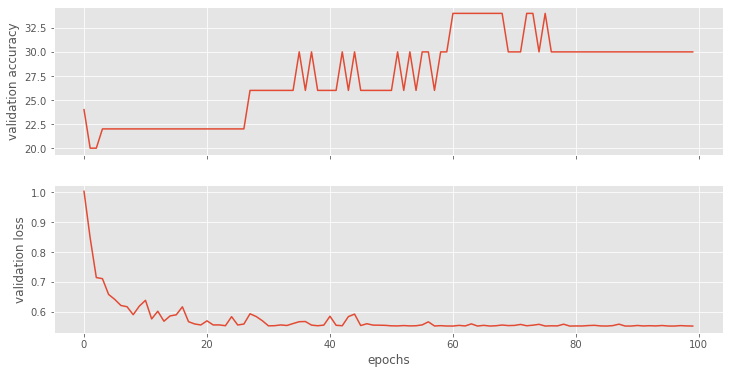

In [15]:
# Gráfica
import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs")